Config

edit code as you wish before use model.

In [1]:
# Dictionary storing network parameters.
params = {
    'batch_size': 128,# Batch size.
    'num_epochs': 360,# Number of epochs to train for.
    'learning_rate': 2e-4,# Learning rate.
    'beta1': 0.5,
    'beta2': 0.999,
    'save_epoch' : 25,# After how many epochs to save checkpoints and generate test output.
    'dataset' : 'Anime'}# Dataset to use. Choose from {MNIST, SVHN, CelebA, FashionMNIST}. CASE MUST MATCH EXACTLY!!!!!

Define Datasets. If you don't have mnist dataset, dataloader will automatically downlaod the dataset. 

This dataloader does not automatically download Anime dataset. 

Therefore, you need to locate the data in the proper location.

In [2]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as dsets

# Directory containing the data. Recomend to using absolute directory rather than relative directory.
root = 'C:/Users/dongh/OneDrive/바탕 화면/개인프로젝트/data/'

def get_data(dataset, batch_size):

    # Get MNIST dataset, this dataset is just for obsetving how infoGAN works.
    if dataset == 'MNIST':
        transform = transforms.Compose([
            transforms.Resize(28),
            transforms.CenterCrop(28),
            transforms.ToTensor()])

        dataset = dsets.MNIST(root+'mnist/', train='train', 
                                download=True, transform=transform)

    # Get CelebA dataset.
    # MUST ALREADY BE DOWNLOADED IN THE APPROPRIATE DIRECTOR DEFINED BY ROOT PATH!
    elif dataset == 'Anime':
        transform = transforms.Compose([
            transforms.Resize(64),
            transforms.CenterCrop(64),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5),
                (0.5, 0.5, 0.5))])

        dataset = dsets.ImageFolder(root=root+"anime", transform=transform)

    # Create dataloader.
    dataloader = torch.utils.data.DataLoader(dataset, 
                                            batch_size=batch_size, 
                                            shuffle=True)

    return dataloader

define Anime model

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

"""
Architecture based on InfoGAN paper.
"""

class Generator(nn.Module):
    def __init__(self):
        super().__init__()

        self.tconv1 = nn.ConvTranspose2d(220, 512, 4, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(512)

        self.tconv2 = nn.ConvTranspose2d(512, 256, 4, 2, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(256)

        self.tconv3 = nn.ConvTranspose2d(256, 128, 4, 2, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(128)

        self.tconv4 = nn.ConvTranspose2d(128, 64, 4, 2, padding=1, bias=False)
        self.bn4 = nn.BatchNorm2d(64)
  
        self.tconv5 = nn.ConvTranspose2d(64, 3, 4, 2, padding=1, bias=False)

    def forward(self, x):
        x = F.relu(self.bn1(self.tconv1(x)))
        x = F.relu(self.bn2(self.tconv2(x)))
        x = F.relu(self.bn3(self.tconv3(x)))
        x = F.relu(self.bn4(self.tconv4(x)))

        img = torch.tanh(self.tconv5(x))

        return img

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 64, 4, 2, 1)

        self.conv2 = nn.Conv2d(64, 128, 4, 2, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(128)

        self.conv3 = nn.Conv2d(128, 256, 4, 2, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(256)
        
        self.conv4 = nn.Conv2d(256, 512, 4, 2, 1, bias=False)
        self.bn4 = nn.BatchNorm2d(512)

    def forward(self, x):
        x = F.leaky_relu(self.conv1(x), 0.2, inplace=True)
        x = F.leaky_relu(self.bn2(self.conv2(x)), 0.2, inplace=True)
        x = F.leaky_relu(self.bn3(self.conv3(x)), 0.2, inplace=True)
        x = F.leaky_relu(self.bn4(self.conv4(x)), 0.2, inplace=True)

        return x

class DHead(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv = nn.Conv2d(512, 1, 4, 1, 0, bias=False)

    def forward(self, x):
        output = torch.sigmoid(self.conv(x))

        return output

class QHead(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(512, 256, 4, 1, 0, bias=False)
        self.bn1 = nn.BatchNorm2d(256)

        self.conv_disc = nn.Conv2d(256, 100, 1)
        
        self.conv_mu = nn.Conv2d(256, 20, 1)
        self.conv_var = nn.Conv2d(256, 20, 1)

    def forward(self, x):
        x = F.leaky_relu(self.bn1(self.conv1(x)), 0.2, inplace=True)

        disc_logits = self.conv_disc(x).squeeze()
        mu = self.conv_mu(x).squeeze()
        var = torch.exp(self.conv_var(x).squeeze())

        return disc_logits, mu, var


Define Utils

In [4]:
import torch
import torch.nn as nn
import numpy as np

def weights_init(m):
    """
    Initialise weights of the model.
    """
    if(type(m) == nn.ConvTranspose2d or type(m) == nn.Conv2d):
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif(type(m) == nn.BatchNorm2d):
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

class NormalNLLLoss:
    """
    Calculate the negative log likelihood
    of normal distribution.
    This needs to be minimised.

    Treating Q(cj | x) as a factored Gaussian.
    """
    def __call__(self, x, mu, var):
        
        logli = -0.5 * (var.mul(2 * np.pi) + 1e-6).log() - (x - mu).pow(2).div(var.mul(2.0) + 1e-6)
        nll = -(logli.sum(1).mean())

        return nll

def noise_sample(n_dis_c, dis_c_dim, n_con_c, n_z, batch_size, device):
    """
    Sample random noise vector for training.

    INPUT
    --------
    n_dis_c : Number of discrete latent code.
    dis_c_dim : Dimension of discrete latent code.
    n_con_c : Number of continuous latent code.
    n_z : Dimension of iicompressible noise.
    batch_size : Batch Size
    device : GPU/CPU
    """

    z = torch.randn(batch_size, n_z, 1, 1, device=device)

    idx = np.zeros((n_dis_c, batch_size))
    if(n_dis_c != 0):
        dis_c = torch.zeros(batch_size, n_dis_c, dis_c_dim, device=device)
        
        for i in range(n_dis_c):
            idx[i] = np.random.randint(dis_c_dim, size=batch_size)
            dis_c[torch.arange(0, batch_size), i, idx[i]] = 1.0

        dis_c = dis_c.view(batch_size, -1, 1, 1)
        
    if(n_con_c != 0):
        # Random uniform between -1 and 1.
        con_c = torch.rand(batch_size, n_con_c, 1, 1, device=device) * 2 - 1

    noise = z
    noise = torch.cat((z, dis_c), dim=1)
    if(n_con_c != 0):
        noise = torch.cat((noise, con_c), dim=1)

    return noise, idx

Train Anime model 

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import time
import random

# Set random seed for reproducibility.
seed = 1123
random.seed(seed)
torch.manual_seed(seed)
print("Random Seed: ", seed)

# Use GPU if available.
device = torch.device("cuda:0" if(torch.cuda.is_available()) else "cpu")
print(device, " will be used.\n")

dataloader = get_data(params['dataset'], params['batch_size'])

# Set appropriate hyperparameters depending on the dataset used.
# The values given in the InfoGAN paper are used.
# num_z : dimension of incompressible noise.
# num_dis_c : number of discrete latent code used.
# dis_c_dim : dimension of discrete latent code.
# num_con_c : number of continuous latent code used.
if(params['dataset'] == 'MNIST'):
    params['num_z'] = 62
    params['num_dis_c'] = 1
    params['dis_c_dim'] = 10
    params['num_con_c'] = 2
elif(params['dataset'] == 'Anime'):
    params['num_z'] = 100
    params['num_dis_c'] = 10
    params['dis_c_dim'] = 10
    params['num_con_c'] = 20



# Plot the training images.
sample_batch = next(iter(dataloader))
plt.figure(figsize=(10, 10))
plt.axis("off")
plt.imshow(np.transpose(vutils.make_grid(
    sample_batch[0].to(device)[ : 100], nrow=10, padding=2, normalize=True).cpu(), (1, 2, 0)))
plt.savefig('Training Images {}'.format(params['dataset']))
plt.close('all')

# Initialise the network.
netG = Generator().to(device)
netG.apply(weights_init)
print(netG)

discriminator = Discriminator().to(device)
discriminator.apply(weights_init)
print(discriminator)

netD = DHead().to(device)
netD.apply(weights_init)
print(netD)

netQ = QHead().to(device)
netQ.apply(weights_init)
print(netQ)

# Loss for discrimination between real and fake images.
criterionD = nn.BCELoss()
# Loss for discrete latent code.
criterionQ_dis = nn.CrossEntropyLoss()
# Loss for continuous latent code.
criterionQ_con = NormalNLLLoss()

# Adam optimiser is used.
optimD = optim.Adam([{'params': discriminator.parameters()}, {'params': netD.parameters()}], lr=params['learning_rate'], betas=(params['beta1'], params['beta2']))
optimG = optim.Adam([{'params': netG.parameters()}, {'params': netQ.parameters()}], lr=params['learning_rate'], betas=(params['beta1'], params['beta2']))

# Fixed Noise
z = torch.randn(100, params['num_z'], 1, 1, device=device)
fixed_noise = z
if(params['num_dis_c'] != 0):
    idx = np.arange(params['dis_c_dim']).repeat(10)
    dis_c = torch.zeros(100, params['num_dis_c'], params['dis_c_dim'], device=device)
    for i in range(params['num_dis_c']):
        dis_c[torch.arange(0, 100), i, idx] = 1.0

    dis_c = dis_c.view(100, -1, 1, 1)

    fixed_noise = torch.cat((fixed_noise, dis_c), dim=1)
    
if(params['num_con_c'] != 0):
    con_c = torch.rand(100, params['num_con_c'], 1, 1, device=device) * 2 - 1
    fixed_noise = torch.cat((fixed_noise, con_c), dim=1)    

real_label = 1
fake_label = 0

# List variables to store results pf training.
img_list = []
G_losses = []
D_losses = []

print("-"*25)
print("Starting Training Loop...\n")
print('Epochs: %d\nDataset: {}\nBatch Size: %d\nLength of Data Loader: %d'.format(params['dataset']) % (params['num_epochs'], params['batch_size'], len(dataloader)))
print("-"*25)

start_time = time.time()
iters = 0

for epoch in range(params['num_epochs']):
    epoch_start_time = time.time()

    for i, (data, _) in enumerate(dataloader, 0):
        # Get batch size
        b_size = data.size(0)
        # Transfer data tensor to GPU/CPU (device)
        real_data = data.to(device)

        # Updating discriminator and DHead
        optimD.zero_grad()
        # Real data
        label = torch.full((b_size, ), real_label, device=device).to(torch.float32)
        output1 = discriminator(real_data)
        probs_real = netD(output1).view(-1)
        loss_real = criterionD(probs_real, label)
        # Calculate gradients.
        loss_real.backward()

        # Fake data
        label.fill_(fake_label)
        noise, idx = noise_sample(params['num_dis_c'], params['dis_c_dim'], params['num_con_c'], params['num_z'], b_size, device)
        fake_data = netG(noise)
        output2 = discriminator(fake_data.detach())
        probs_fake = netD(output2).view(-1)
        loss_fake = criterionD(probs_fake, label)
        # Calculate gradients.
        loss_fake.backward()

        # Net Loss for the discriminator
        D_loss = loss_real + loss_fake
        # Update parameters
        optimD.step()

        # Updating Generator and QHead
        optimG.zero_grad()

        # Fake data treated as real.
        output = discriminator(fake_data)
        label.fill_(real_label)
        probs_fake = netD(output).view(-1)
        gen_loss = criterionD(probs_fake, label)

        q_logits, q_mu, q_var = netQ(output)
        target = torch.LongTensor(idx).to(device)
        # Calculating loss for discrete latent code.
        dis_loss = 0
        
        for j in range(params['num_dis_c']):
            dis_loss += criterionQ_dis(q_logits[:, j*10 : j*10 + 10], target[j])
            
        # Calculating loss for continuous latent code.
        con_loss = 0
        if (params['num_con_c'] != 0):
            con_loss = criterionQ_con(noise[:, params['num_z']+ params['num_dis_c']*params['dis_c_dim'] : ].view(-1, params['num_con_c']), q_mu, q_var)

        # Net loss for generator.
        G_loss = gen_loss + dis_loss
        # Calculate gradients.
        G_loss.backward()
        # Update parameters.
        optimG.step()

        # Check progress of training.
        if i != 0 and i%100 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f'
                  % (epoch+1, params['num_epochs'], i, len(dataloader), 
                    D_loss.item(), G_loss.item()))

        # Save the losses for plotting.
        G_losses.append(G_loss.item())
        D_losses.append(D_loss.item())

        iters += 1

    epoch_time = time.time() - epoch_start_time
    print("Time taken for Epoch %d: %.2fs" %(epoch + 1, epoch_time))
    # Generate image after each epoch to check performance of the generator. Used for creating animated gif later.
    with torch.no_grad():
        gen_data = netG(fixed_noise).detach().cpu()
    img_list.append(vutils.make_grid(gen_data, nrow=10, padding=2, normalize=True))

    # Generate image to check performance of generator.
    if((epoch+1) == 1 or (epoch+1) % 5 == 0):
        with torch.no_grad():
            gen_data = netG(fixed_noise).detach().cpu()
        plt.figure(figsize=(10, 10))
        plt.axis("off")
        plt.imshow(np.transpose(vutils.make_grid(gen_data, nrow=10, padding=2, normalize=True), (1,2,0)))
        plt.savefig("Epoch_%d {}".format(params['dataset']) %(epoch+1))
        plt.close('all')

    # Save network weights.
    if (epoch+1) % params['save_epoch'] == 0:
        torch.save({
            'netG' : netG.state_dict(),
            'discriminator' : discriminator.state_dict(),
            'netD' : netD.state_dict(),
            'netQ' : netQ.state_dict(),
            'optimD' : optimD.state_dict(),
            'optimG' : optimG.state_dict(),
            'params' : params
            }, 'checkpoint/model_epoch_%d_{}'.format(params['dataset']) %(epoch+1))

training_time = time.time() - start_time
print("-"*50)
print('Training finished!\nTotal Time for Training: %.2fm' %(training_time / 60))
print("-"*50)

# Generate image to check performance of trained generator.
with torch.no_grad():
    gen_data = netG(fixed_noise).detach().cpu()
plt.figure(figsize=(10, 10))
plt.axis("off")
plt.imshow(np.transpose(vutils.make_grid(gen_data, nrow=10, padding=2, normalize=True), (1,2,0)))
plt.savefig("Epoch_%d_{}".format(params['dataset']) %(params['num_epochs']))

# Save network weights.
torch.save({
    'netG' : netG.state_dict(),
    'discriminator' : discriminator.state_dict(),
    'netD' : netD.state_dict(),
    'netQ' : netQ.state_dict(),
    'optimD' : optimD.state_dict(),
    'optimG' : optimG.state_dict(),
    'params' : params
    }, 'checkpoint/model_final_{}'.format(params['dataset']))


# Plot the training losses.
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.savefig("Loss Curve {}".format(params['dataset']))

# Animation showing the improvements of the generator.
fig = plt.figure(figsize=(10,10))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
anim = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
anim.save('infoGAN_{}.gif'.format(params['dataset']), dpi=80, writer='imagemagick')
plt.show()

Random Seed:  1123
cuda:0  will be used.

Generator(
  (tconv1): ConvTranspose2d(220, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (tconv2): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (tconv3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (tconv4): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (tconv5): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
)
Discriminator(
  (conv1): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2):

KeyboardInterrupt: 

Anime Generator: Running this code will generate output images of the Generator.
You can use other saved weights by editing input parameter of torch.load()

Generator(
  (tconv1): ConvTranspose2d(220, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (tconv2): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (tconv3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (tconv4): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (tconv5): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
)


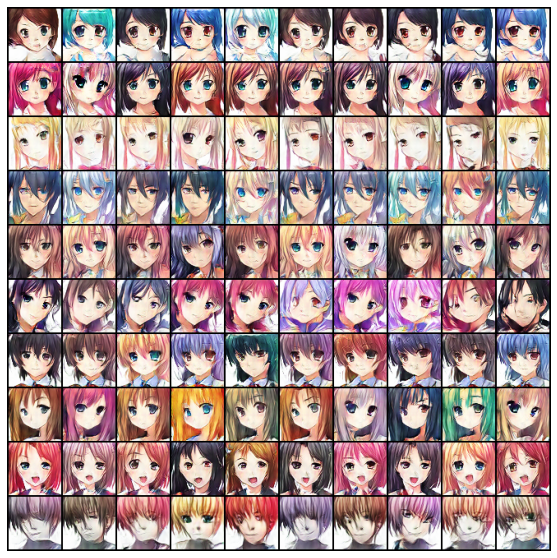

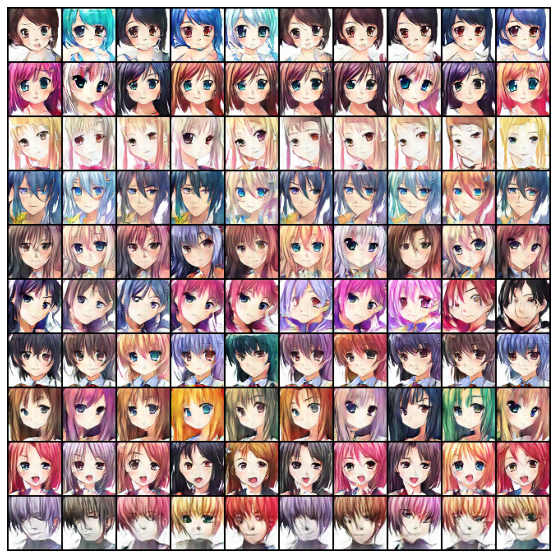

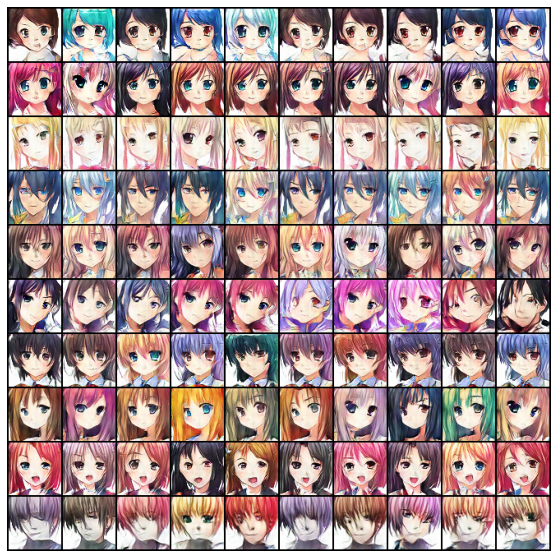

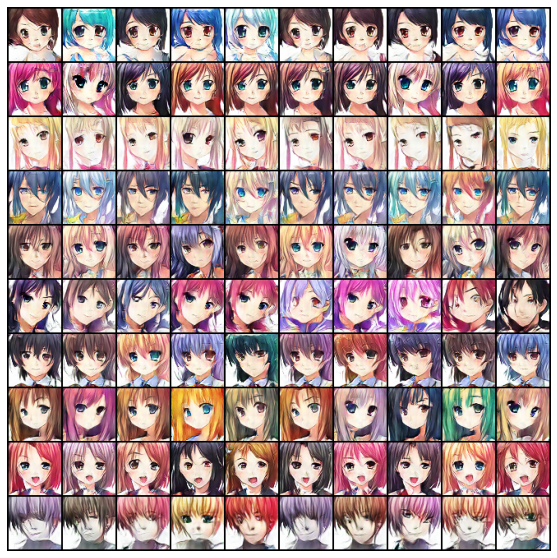

In [14]:
import torch 
import torchvision.utils as vutils
import numpy as np 
import matplotlib.pyplot as plt

# Load the checkpoint file
state_dict = torch.load("C:/Users/dongh/OneDrive/바탕 화면/개인프로젝트/infoGAN_with_10dis_20con/checkpoint/model_epoch_360_Anime")

# Set the device to run on: GPU or CPU.
device = torch.device("cuda:0" if(torch.cuda.is_available()) else "cpu")
# Get the 'params' dictionary from the loaded state_dict.
params = state_dict['params']

# Create the generator network.
netG = Generator().to(device)
# Load the trained generator weights.
netG.load_state_dict(state_dict['netG'])
print(netG)

c = np.linspace(-2, 2, 10).reshape(1, -1)
c = np.repeat(c, 10, 0).reshape(-1, 1)
c = torch.from_numpy(c).float().to(device)
c = c.view(-1, 1, 1, 1)

zeros = torch.zeros(100, 1, 1, 1, device=device)

c10 = torch.cat((c,c,c,c,c,c,c,c,c,c), dim = 1)
zeros10 = torch.cat((zeros,zeros,zeros,zeros,zeros,zeros,zeros,zeros,zeros,zeros), dim = 1)

# Continuous latent code.
c2 = torch.cat((c10, zeros10), dim=1)
c3 = torch.cat((zeros10, c10), dim=1)
c4 = torch.cat((c10,c10),dim=1)
c5 = torch.cat((zeros10,zeros10), dim = 1)

# Discrete latent code.
idx = np.arange(10).repeat(10)
dis_c_base = torch.zeros(100, 10, 1, 1, device=device)
dis_c_base[torch.arange(0, 100), idx] = 1.0

dis_c_fixed = torch.zeros(100, 10, 1, 1, device=device)
dis_c_fixed[torch.arange(0,100),0]=1.0

dis_c_variation = torch.zeros(100,10,1,1,device=device)
dis_c_variation[np.arange(100),np.tile(np.arange(10),10)] = 1.0

dis_c = torch.cat((dis_c_base, dis_c_base, dis_c_base, dis_c_base, dis_c_base, dis_c_base, dis_c_base, dis_c_base, dis_c_base, dis_c_base),dim = 1)


z = torch.randn(100, params['num_z'], 1, 1, device=device)
# To see variation along all discrete latent codes (Vertically) and c2 (Horizontally)
noise1 = torch.cat((z, dis_c,c2), dim=1)
# To see variation along all discrete latent codes (Vertically) and c3 (Horizontally)
noise2 = torch.cat((z, dis_c,c3), dim=1)
# To see variation along all discrete latent codes (Vertically) and c4 (Horizontally)
noise3 = torch.cat((z, dis_c,c4), dim=1)
# To see variation along all discrete latent codes (Vertically) and c5 (Horizontally)
noise4 = torch.cat((z, dis_c,c5), dim=1)

noise_list = [noise1,noise2, noise3, noise4]

for noise in noise_list:
    # Generate image.
    with torch.no_grad():
        generated_img1 = netG(noise).detach().cpu()
    # Display the generated image.
    fig = plt.figure(figsize=(10, 10))
    plt.axis("off")
    plt.imshow(np.transpose(vutils.make_grid(generated_img1, nrow=10, padding=2, normalize=True), (1,2,0)))
    plt.show()
